# Lab 07 - Bagging Decision Trees
In the previous lab we discussed the [bias-variance tradeoff](https://github.com/GreenGilad/IML.HUJI/blob/main/lab/Lab%2006%20-%20Bias-Variance%20Trade-off.ipynb) and saw how:
- The less complex a model is the higher is its variance and lower is its bias. We say in this case that the model is underfitted.
- The more complex a model is the higher is its bias and lower is its variance. We say in this case that the model is overfitted.

In this lab we will use the power of ensemble methods to fit a set of models, each with a low complexity, to achieve better performances while avoiding overfitting.

In [58]:
import sys
sys.path.append("../")
from utils import *

In [59]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.utils import resample
from scipy.stats import norm
import matplotlib
from matplotlib import pyplot as plt
from sklearn import metrics
import re

symbols = np.array(["circle", "x"])

## Gaussian Estimation With an Ensemble
The first model we'll obseve is estimation of the mean and variance of a gaussian. We'll compare the classic estimator (based on a single sample dataset of size m) to the ensemble estimator. The ensemble is made by sampling multiple bootstrap datasets randomly with replacements from the classic estimator's dataset, and then *bagging* them together. Its estimators are calculated by averaging the mean's and variance's estimators of each dataset.

In [60]:
class Gaussian:
    def __init__(self):
        self.mu, self.var = None, None
    
    def fit(self, X):
        self.mu, self.var = np.mean(X), np.var(X, ddof=1)
        return self
    
    def pdf(self, X):
        return norm.pdf(X, self.mu, self.var)

In [61]:
def bootstrap_gaussian_predictions(X, num_bootstraps, axis):
    y_array = []
    mu_hat_array = np.zeros(num_bootstraps)
    var_hat_array = np.zeros(num_bootstraps)
    
    for i in range(num_bootstraps):
        bag = Gaussian().fit(np.random.choice(X, X.size, replace=True)) # fit over a sample taken from X (with replacements)
        mu_hat_array[i], var_hat_array[i] = bag.mu, bag.var
        y_array.append(bag.pdf(axis))
        
    return y_array, mu_hat_array, var_hat_array

In [62]:
np.random.seed(1)

mu, var, m = 6, 1, 30
axis = np.linspace(3, 9, 1000)

X = np.random.normal(mu, var, size=m)  # Dataset of a single sample of size m from the gaussian

In [63]:
real_pdf = norm.pdf(axis, mu, var)
pdf_classic_sample = Gaussian().fit(X).pdf(axis)

In [64]:
num_bootstraps = 50
pdf_bootstrap_samples, _, _ = bootstrap_gaussian_predictions(X, num_bootstraps, axis)

In [65]:
fig = go.Figure([go.Scatter(x=axis, y=real_pdf, mode='lines', line=dict(width=3, color="rgb(204,68,83)"), name=fr'$N({mu}, {var})$'),
           go.Scatter(x=axis, y=pdf_classic_sample, mode='lines', line=dict(width=3, color="rgb(6,106,141)"), name=r'$\text{Clasic  Estimation}$')],
          layout=go.Layout(barmode='overlay',
                           title=r"$\text{(1) Estimation of mean and variance of a normal distribution}$", 
                           xaxis_title="r$x$", 
                           yaxis_title="density",
                           height=300))

for idx, pdf_bootstrap in enumerate(pdf_bootstrap_samples):
    if idx == 0:
        fig.add_trace(go.Scatter(x=axis, y=pdf_bootstrap, mode='lines', line=dict(width=2, color="rgba(166,166,166, 0.3)"), name=r'$\text{Bootstraps Estimations}$'))
    else:
        fig.add_trace(go.Scatter(x=axis, y=pdf_bootstrap, mode='lines', line=dict(width=2, color="rgba(166,166,166, 0.3)"), showlegend=False))

fig.show()

In order to calculate the mean's and variance's estimators from the ensemble we'll need to find them for each bootstrap dataset and then average them all:

In [66]:
# Classic:
classic_sample = Gaussian().fit(X)
mu_hat, var_hat = classic_sample.mu, classic_sample.var

# Bootstrap:
_, mu_hats, var_hats = bootstrap_gaussian_predictions(X, num_bootstraps, axis) #mean and variance estimators of all the dataests
mu_hat_bootstrap, var_hat_bootstrap = np.mean(mu_hats), np.mean(var_hats)

estimators_table = pd.DataFrame([[mu, var], [mu_hat, var_hat], [mu_hat_bootstrap, var_hat_bootstrap]],
                               columns=['Mean', 'Variance'], index=['Real Value', 'Classic Estimator', 'Bootstrap Estimator'])
estimators_table

Mean  Variance
Real Value           6.000000  1.000000
Classic Estimator    5.940061  1.053425
Bootstrap Estimator  5.938760  1.055354

Now try to change m (the samples' size) into a greater number and run again the code above. How the results were changed? And how about fewer datasets in the ensemble (num_bootstrap)?

## Decision Trees Ensemble
Now we'll observe the process over classification of 2D points. It's a more complex problem, and we'll see that the effect of the ensemble here is more significant.

We'll use the hypothesis class of decision trees and *bag* multiple trees into a single ensemble.
We'll begin with sampling a 2D dataset to classify, Where the points' real classes are determined by a decision tree with depth 
**5**.

In [67]:
np.random.seed(7)

d, n_train, n_test = 5, 2000, 500
X, y = create_data_bagging_utils(d=d, n_samples = n_train + n_test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=n_test, random_state=42)


go.Figure(data=go.Scatter(x=X[:,0], y=X[:,1], mode="markers", showlegend=False,
                           marker=dict(color=y, symbol=symbols[y], colorscale=[custom[0], custom[-1]], size=5)), 
          layout=go.Layout(title=rf"$\textbf{{(2) Tree Dataset - True Depth {d}}}$",
                           xaxis_title=r"$x_1$",
                           yaxis_title=r"$x_2$",
                           width=700, height=350)
         )

In [68]:
def replace_text(obj):  # A function to make the decision tree's representation cleaner
    if type(obj) == matplotlib.text.Annotation:
        for old, new in [("X\[0]",r"$x_1$"), ("X\[1]",r"$x_2$"), ("samples[^$]*class","class")]: obj.set_text(re.sub(old, new, obj.get_text()))
    return obj

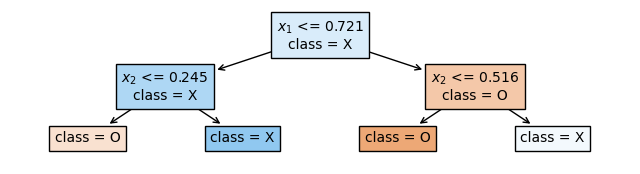

In [69]:
depth=2  # The depth of the single decision tree and of each tree in the ensemble
tree = DecisionTreeClassifier(max_depth=depth).fit(X_train, y_train)

# Tree representation
fig, ax = plt.subplots(figsize = (8,2))
_ = plot_tree(tree, filled = True, impurity=False, class_names=["O", "X"], fontsize=10, ax = ax)
ax.properties()['children'] = [replace_text(i) for i in ax.properties()['children']]

# Coloring labels representation
lims = np.array([X.min(axis=0), X.max(axis=0)]).T + np.array([-.01, .01])
go.Figure([decision_surface(tree.predict, lims[0], lims[1], showscale=False),
                go.Scatter(x=X[:,0], y=X[:,1], mode="markers", showlegend=False,
                           marker=dict(color=y, symbol=symbols[y], colorscale=[custom[0], custom[-1]],size=4, 
                                       line=dict(color="black", width=1)) )], 
          layout=go.Layout(title=rf"$\textbf{{(3) Decision Bounderies of a Single {depth}-Depth Decision Tree}}$",
                           xaxis_title=r"$x_1$", yaxis_title=r"$x_2$",
                           width=650, height=350))


Now, Let's create a Tree Ensemble of 100 trees of the same depth as the single decision tree we trained, and fit it with our train data. Each tree in the ensemble is trained over a bootstrap dataset, where each bootstrap dataset is built by choosing samples from the train data randomly with replcement, that means it is built in the next way:
1. choose a sample randomly from the train data and add it to the bootstrap dataset
2. keep the sample in the train data so that it can be re-selected to the same bootstrap dataset (and of course to the other bootstrap datasets)

In [70]:
class TreeEnsemble:
    def __init__(self, num_of_trees, d):
        self.trees = []
        self.num_of_trees = num_of_trees
        self.partial = num_of_trees
        self.depth = d
        
    def fit_bootstrap_tree(self, X, y):
        idx = resample(range(len(X)), replace = True, n_samples = len(X))
        return DecisionTreeClassifier(max_depth=self.depth).fit(X[idx], y[idx])
        
    def fit(self, X, y):
        self.trees = [self.fit_bootstrap_tree(X, y) for _ in range(self.num_of_trees)]  # this line can be executed in parallel
        return self
    
    def predict(self, X):
        return self.partial_predict(X, self.num_of_trees)
    
    def partial_predict(self, X, num_trees):
        self.partial = num_trees
        samples_proba = self.predict_proba(X)  # samples_proba[0]: probablity for class "0". samples_proba[1]: probablity for class "1".
        return np.argmax(samples_proba, axis=1)  # returns for each sample, the index of the maximum probability class
        
    def predict_proba(self, X):
        # This function calculates the probability of each class ("0"/"1") for each sample.
        trees_mean = np.mean([self.trees[t].predict(X) for t in range(0, min(self.partial, self.num_of_trees))], axis=0)
        return np.stack((1-trees_mean, trees_mean), axis=1)

In [71]:
bootstrap_trees = TreeEnsemble(100, depth).fit(X_train, y_train)

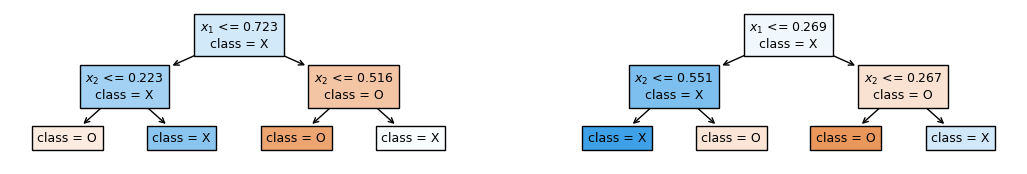

In [72]:
trees_to_rep = [0, 1]
fig = make_subplots(rows=1, cols=2, subplot_titles=[rf"$\text{{Tree {i+1}}}$" for i in trees_to_rep],
                    horizontal_spacing = 0.01, vertical_spacing=.03)
_, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (13,2))


for i, t in enumerate(trees_to_rep):
    fig.add_traces([decision_surface(bootstrap_trees.trees[t].predict, lims[0], lims[1], showscale=False),
                    go.Scatter(x=X[:,0], y=X[:,1], mode="markers", showlegend=False,
                               marker=dict(color=y, symbol=symbols[y], colorscale=[custom[0], custom[-1]],
                                           size=4, line=dict(color="black", width=0.7)) )],
                   rows=1, cols=i+1)
    plot_tree(bootstrap_trees.trees[t], filled = True, impurity=False, class_names=["O", "X"], fontsize=9, ax = axes[i])
    axes[i].properties()['children'] = [replace_text(j) for j in axes[i].properties()['children']]

fig.update_layout(width=950, height=250).update_xaxes(visible=False).update_yaxes(visible=False)
fig.update(layout = go.Layout(title=rf"$\textbf{{(4) Ensemble's First and Second Trees' Decision Bounderies}}$"))
fig.show()
plt.show()


The ensemble's prediction of each point is made by its class majority vote. It allows complexer patterns than a single 2-depth decision tree.

In [73]:
go.Figure([decision_surface(bootstrap_trees.predict, lims[0], lims[1], showscale=False),
          go.Scatter(x=X[:,0], y=
                     X[:,1], mode="markers", showlegend=False,
                           marker=dict(color=y, symbol=symbols[y], colorscale=[custom[0], custom[-1]],
                                       size=5, line=dict(color="black", width=1)))], 
          layout=go.Layout(title=rf"$\textbf{{(5) Desicion Bounderies of Entire Ensemble}}$",
                           xaxis_title=r"$x_1$",
                           yaxis_title=r"$x_2$",
                           width=800, height=400)
         )

We can see that the ROC curve of the ensemble is better than of the single tree, and accordingly the loss of the ensemble decreases as a function of the amount of trees in it.

In [74]:
fig = go.Figure(layout=go.Layout(title=rf"$\textbf{{(6) ROC Curves, real depth={d}, trees depth={depth}}}$", margin=dict(t=100),
                                 width=700, height=350))
names = [r'$\text{Single Tree}$', r'$\text{Trees Ensemble}$']
for i, model in enumerate([tree, bootstrap_trees]):
    fpr, tpr, th = metrics.roc_curve(y_test, model.predict_proba(X_test)[:, 1])
    fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name=names[i]))
fig.show()

In [75]:
tree_loss = np.sum(tree.predict(X_test) != y_test) / len(y_test)

ensemble_losses = []
nums = list(range(1, 251))
ensemble = TreeEnsemble(max(nums), depth).fit(X_train, y_train)
for num_trees in nums:
    ensemble_losses.append(np.sum(ensemble.partial_predict(X_test, num_trees) != y_test) / len(y_test))

In [76]:
go.Figure([go.Scatter(x=nums, y=ensemble_losses, mode='lines', name=r"$\text{Ensemble}$"), 
                 go.Scatter(x=nums, y=[tree_loss for i in nums], mode='lines', name=r"$\text{Single Tree}$")],
                layout=go.Layout(title=rf"$\textbf{{(7) Loss as a Function of the Number of Trees in the Ensemble}}$",
                                 margin=dict(t=100),
                                 xaxis_title=r"$\text{Number of Trees}$", yaxis_title=r"$\text{Loss}$",
                                 width=700, height=370))

Now, let's see what happens if we add correlation between the tree in th ensemmble. We'll give each tree a weight in the range (0,1] randomly, and give the ensemble a correlation parameter $\rho$. For each tree, if its weight is greater than $\rho$, its decision wouldn't change. But is its weight is smaller, its decision would change to the decision of the first tree in the ensemble. That way we can add dependency to the tree's decisions.

In [77]:
class CorrelatedTreeEnsemble(TreeEnsemble):
    def __init__(self, num_of_trees, d, ro=0):
        super().__init__(num_of_trees, d)
        self.ro = ro
    
    def predict_proba(self, X):
        random_vec = np.random.uniform(low=0, high=1, size=(self.num_of_trees,))
        trees_decisions = [self.trees[0].predict(X)]
        for i in range(1, self.num_of_trees):
            if random_vec[i] >= self.ro:
                trees_decisions.append(self.trees[i].predict(X))
            else:
                trees_decisions.append(trees_decisions[0])
        trees_mean = np.mean(trees_decisions, axis=0)
        return np.stack((1-trees_mean, trees_mean), axis=1)

In [78]:
ros = np.arange(0, 1.1, 0.05)

corr_ensemble = CorrelatedTreeEnsemble(30, depth).fit(X_train, y_train)
corr_ensemble_losses = []
for ro in ros:
    corr_ensemble.ro = ro
    corr_ensemble_losses.append(np.sum(corr_ensemble.predict(X_test) != y_test) / len(y_test))

In [79]:
go.Figure([go.Scatter(x=ros, y=corr_ensemble_losses, mode='lines', name=r"$\text{Correlated Ensemble}$")], 
                      layout=go.Layout(title=rf"$\textbf{{(8) Loss as a Function of }}\rho$", margin=dict(t=100),
                                 xaxis_title=r"$\rho$", yaxis_title=r"$\text{Loss}$",
                                 width=700, height=370))